### **🛠️데이터 처리 흐름**

1. **입력**: 전체 CSI 데이터가 게이팅 네트워크(`ViewClassifier`)에 입력
2. **분류**: 게이팅 네트워크는 가장 확률이 높은 뷰(View)를 결정
3. **전달**: 선택된 뷰에 해당하는 데이터 조각만이 해당 전문가 네트워크(`LocalizationCNN`)에 전달
4. **회귀**: 최종적으로, 선택된 전문가가 **(x, y) 좌표**를 예측하여 출력

### **✔️ ViewClassifier(DNN)**

- **역할**: 전체 CSI 특징 벡터를 입력받아, 데이터가 사전 정의된 4개의 '뷰(View)' 중 어디에 속하는지 분류
- **구조**: 다층 퍼셉트론(MLP)으로, 여러 완전 연결 레이어(Fully-connected layers)로 구성
- **입력**: 전체 CSI 특징 벡터(`data[141, 10, 1890, 10]`)
- **출력**: 4개 뷰에 대한 소프트맥스(Softmax) 확률

### **✔️ LocalizationCNN(CNN)**

- **역할**: 총 4개가 존재하며, 각 ViewClassifier가 할당한 특정 '뷰'의 데이터 조각만을 입력받아 실제 **위치(x, y) 좌표를 추정**하는 회귀(Regression) 수행
- **구조**: 뷰 데이터를 작은 2D 이미지(`630x10`)처럼 간주하여 CNN 수행
- **입력**: 특정 뷰에 해당하는 CSI 데이터 조각
- **출력**: 정규화된 (x, y) 좌표

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from pathlib import Path

# --- 1) 하이퍼파라미터 & 상수 정의 ---
# 사용자가 제공한 get_input 함수의 인자와 상수에 맞춰 재정의
INPUT2            = 1890 # CSI 이미지의 세로 길이 (주파수/서브캐리어 개수 또는 AP 특성 개수)
NUM_DATA_CHANNELS = 10   # CSI 이미지의 가로 길이 (각 서브캐리어/AP에 대한 데이터 채널 수: amplitude, phase, imaginary value 등)

# ViewClassifier에 들어가는 전체 CSI 데이터의 특성 개수 (세로 * 가로)
INPUT_FEATURE_COUNT = INPUT2 * NUM_DATA_CHANNELS # 18900

# LocalizationCNN에 들어가는 뷰별 CSI 데이터의 특성 개수 (뷰별 세로 * 가로)
INPUT_VIEW_FEATURE_COUNT = 630 * NUM_DATA_CHANNELS # 즉, 뷰별로 추출된 데이터의 평탄화된 크기: 6300

# LocalizationCNN 내부 선형 레이어의 중간 노드 수 (이전 CNN 코드에서 가져옴)
NODE_LOC_CNN_FC = 1024 

OUTPUT         = 2       # 회귀 모델의 출력 차원 (x,y 좌표)
NUM_VIEWS      = 4       # 총 뷰(View)의 개수
ORIG_TRAIN_SAMPLES = 100 # 학습 데이터 포인트 수 (TOTAL_POINTS - TP)
ORIG_TEST_SAMPLES  = 41  # 테스트 데이터 포인트 수 (TP)
TOTAL_POINTS = ORIG_TRAIN_SAMPLES + ORIG_TEST_SAMPLES # 전체 위치(point)의 개수

# 각 위치(point)당 실험 횟수 (파일에서 읽는 실제 데이터 개수에 맞춤)
# 이전에 100으로 설정되어 있었으나, 파일의 실제 데이터 구조에 맞춰 10으로 변경됨
EXPERIMENT     = 10      

EPOCHS         = 100     # 에폭(Epoch) 수
LR_BASE      = 5e-4    # 학습률 (Learning Rate)

max_x, max_y = 2295.0, 2340.0 # x, y 좌표의 최대값 (정규화에 사용)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[정보] 사용 중인 장치: {device}")

# --- 2) 좌표 데이터 및 정규화 ---
# 각 위치에 대한 실제 x, y 좌표 값 리스트
y1_all = [
    0, 127.5, 255.0, 382.5, 510.0, 637.5, 765.0, 892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0,
    1657.5, 1785.0, 1912.5, 2040.0, 2167.5, 2295.0,
    0, 127.5, 255.0, 382.5, 510.0, 637.5, 765.0, 892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0,
    1657.5, 1785.0, 1912.5, 2040.0, 2167.5, 2295.0,
    0, 127.5, 255.0, 360, 510.0, 637.5, 765.0, 892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0,
    1657.5, 1785.0, 1912.5, 2040.0, 2167.5, 2295.0,
    892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0,
    892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0,
    765.0, 892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0, 1657.5,
    637.5, 765, 892.5, 1657.5, 1785,
    510, 637.5, 1657.5, 1785.0,
    382.5, 510, 637.5, 1657.5, 1785, 1912.5, 2040.0,
    382.5, 510, 637.5, 1657.5, 1785, 1912.5, 2040.0,
    382.5, 510, 637.5, 1657.5, 1785, 1912.5, 2040.0,
    382.5, 510, 637.5, 1785, 1912.5, 2040.0,
    382.5, 510.0, 637.5, 765.0, 892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0, 1657.5, 1785.0,
    1912.5, 2040.0,
    382.5, 510.0, 637.5, 765.0, 892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0, 1657.5, 1785.0,
    1912.5, 2040.0,
]
y2_all = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180,
    360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360,
    540, 540, 540, 540, 540, 540,
    720, 720, 720, 720, 720, 720,
    900, 900, 900, 900, 900, 900, 900, 900,
    1080, 1080, 1080, 1080, 1080,
    1260, 1260, 1260, 1260,
    1440, 1440, 1440, 1440, 1440, 1440, 1440,
    1620, 1620, 1620, 1620, 1620, 1620, 1620,
    1800, 1800, 1800, 1800, 1800, 1800, 1800,
    1980, 1980, 1980, 1980, 1980, 1980,
    2160, 2160, 2160, 2160, 2160, 2160, 2160, 2160, 2160, 2160, 2160, 2160, 2160, 2160,
    2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340,
]

# x, y 좌표를 최대값으로 나누어 0~1 사이로 정규화
coord_np = np.stack([np.array(y1_all) / max_x, np.array(y2_all) / max_y], axis=1).astype(np.float32)

# --- 3) 뷰 인덱스 & 분할 정의 ---
# 각 뷰에 속하는 위치(point)들의 인덱스 리스트
view1 = [80, 81, 84, 85, 89, 90, 91, 92, 96, 97, 98, 99, 103, 104, 106, 110, 111, 112,
          120, 122, 124, 126, 134, 135, 136, 137, 138, 139, 140]
view2 = [77, 78, 79, 82, 83, 86, 87, 88, 93, 94, 95, 100, 102, 107, 108, 109, 113, 114,
          116, 118, 119, 127, 128, 129, 130, 131, 132, 133]
view3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 21, 23, 25, 27, 28, 38, 39,
          40, 41, 42, 43, 44, 45, 46, 47, 57, 59, 63, 64, 65, 69, 70, 71, 72]
view4 = [10, 11, 12, 13, 14, 15, 16, 17, 18, 29, 30, 32, 34, 36, 37,
          48, 49, 50, 51, 52, 53, 54, 55, 56, 60, 62, 66, 67, 68, 73, 74, 75, 76]

# 테스트 세트에 포함되는 위치 인덱스
test1 = [105, 121, 123, 125]
test2 = [101, 115, 117]
test3 = [20, 22, 24, 26, 58]
test4 = [31, 33, 35, 61]

# 전체 테스트 인덱스 리스트와 학습 인덱스 리스트 생성
test_indices  = sorted(np.concatenate((test1, test2, test3, test4)))
train_indices = [i for i in range(TOTAL_POINTS) if i not in test_indices]
TP = len(test_indices) # 테스트 포인트의 개수

# --- 4) 뷰 레이블 생성 ---
def make_view_label(indices, groups):
    """ 주어진 인덱스들에 대해 뷰 그룹에 속하는지 여부를 0 또는 1로 나타내는 레이블을 생성 """
    L = np.zeros((len(indices), NUM_VIEWS), dtype=np.float32)
    for ri, idx in enumerate(indices):
        belongs = [v for v, grp in enumerate(groups) if idx in grp]
        if belongs: # 인덱스가 어떤 뷰에라도 속하는 경우
            w = 1.0 / len(belongs) # 여러 뷰에 속할 경우 가중치 분배
            for v in belongs:
                L[ri, v] = w
    return L

# 학습 및 테스트 데이터에 대한 뷰 레이블 생성
train_view_label = torch.from_numpy(
    make_view_label(train_indices, [view1, view2, view3, view4])
).to(device)
test_view_label  = torch.from_numpy(
    make_view_label(test_indices, [view1, view2, view3, view4])
).to(device)


# --- 5) 입력 데이터 로드 ---
def get_input(filename, sample_count, experiment_count, csi_height, csi_width):
    """
    지정된 파일에서 CSI 데이터를 로드하고 주어진 형태로 재구성합니다.
    CSI 데이터는 (sample_count, experiment_count, csi_height, csi_width) 형태가 됩니다.
    
    Args:
        filename (str): 데이터 파일 경로.
        sample_count (int): 샘플 개수 (TOTAL_POINTS).
        experiment_count (int): 각 샘플당 실험 횟수 (EXPERIMENT).
        csi_height (int): CSI 이미지의 세로 길이 (INPUT2).
        csi_width (int): CSI 이미지의 가로 길이 (NUM_DATA_CHANNELS).
    """
    # CSI 이미지는 (세로, 가로) 형태로 구성됨
    data = np.zeros((sample_count, experiment_count, csi_height, csi_width), dtype=np.float32) 

    with open(filename, 'r') as f:
        diag_temp = f.read().split()

    idx = 0
    # 파일에서 데이터를 읽어 numpy 배열에 채우는 루프
    # 가정: 파일은 sample -> experiment -> csi_height(세로) -> csi_width(가로) 순서로 저장됨

    for i in range(sample_count):
        for p in range(experiment_count):
            for m in range(csi_height): # CSI 이미지의 세로 길이
                for l in range(csi_width): # CSI 이미지의 가로 길이
                    data[i, p, m, l] = float(diag_temp[idx])
                    idx += 1
    return data

# 전체 CSI 데이터 로드 
# (TOTAL_POINTS, EXPERIMENT=10, INPUT2=1890, NUM_DATA_CHANNELS=10) 형태로 로드
full_data_raw = get_input("result_250227_all_plus_amp.txt",
                          TOTAL_POINTS,        # 샘플 개수 (141)
                          EXPERIMENT,          # 각 샘플당 실험 횟수 (10)
                          INPUT2,              # CSI 이미지 세로 (1890)
                          NUM_DATA_CHANNELS)   # CSI 이미지 가로 (10)

# 학습 및 테스트 데이터를 인덱스에 따라 분리
train_data_raw_csi = full_data_raw[train_indices] # (ORIG_TRAIN_SAMPLES, EXPERIMENT, 1890, 10)
test_data_raw_csi  = full_data_raw[test_indices]  # (ORIG_TEST_SAMPLES, EXPERIMENT, 1890, 10)


# ViewClassifier 학습을 위한 데이터 준비: 각 위치별 모든 실험 데이터 평균 -> 평탄화
# 원본 형태: (num_train_points, EXPERIMENT, CSI이미지세로, CSI이미지가로)
# 1. 각 experiment 내의 데이터를 평탄화: (num_train_points, EXPERIMENT, CSI이미지세로 * CSI이미지가로)
train_data_flat_per_exp = train_data_raw_csi.reshape(train_data_raw_csi.shape[0], 
                                                     train_data_raw_csi.shape[1], 
                                                     INPUT_FEATURE_COUNT) 
# 2. experiment 축으로 평균: (num_train_points, CSI이미지세로 * CSI이미지가로)
train_data_avg_flat_dnn = np.mean(train_data_flat_per_exp, axis=1) 
print(f"[정보] ViewClassifier (DNN)를 위한 평균 및 평탄화된 학습 데이터 형태: {train_data_avg_flat_dnn.shape}")

# PyTorch 텐서로 변환하여 GPU/CPU에 로드
bx_train = torch.from_numpy(train_data_avg_flat_dnn).to(device)
by_train = torch.from_numpy(coord_np[train_indices]).to(device)
uv_train = train_view_label # 이미 장치에 로드됨

# 테스트 데이터 (평균화되지 않은 원본 데이터, 각 실험별 평가에 사용)
test_data_tensor = torch.from_numpy(test_data_raw_csi).to(device) # (TP, EXPERIMENT, 1890, 10)
test_lbls_tensor = torch.from_numpy(coord_np[test_indices]).to(device) # (TP, 2)


# --- 6) 모델 정의 ---
class ViewClassifier(nn.Module):
    """ 전체 CSI 이미지 데이터를 입력으로 받아 어떤 뷰에 속하는지 분류하는 DNN 모델 """
    def __init__(self):
        super().__init__()
        # DNN 구조 (제공된 DNN 코드와 동일)
        self.net = nn.Sequential(
            nn.Linear(INPUT_FEATURE_COUNT, 1024), # 입력은 평탄화된 (CSI이미지세로 * CSI이미지가로) 차원
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, NUM_VIEWS) # 최종 출력은 뷰의 개수
        )
    def forward(self, x):
        # x는 이미 DNN 입력에 맞게 평탄화된 형태 (batch_size, INPUT_FEATURE_COUNT)로 가정
        logit = self.net(x)
        return logit, torch.softmax(logit, dim=1) # 로짓과 확률 반환

class LocalizationCNN(nn.Module):
    """ 특정 뷰에 특화된 CSI 이미지 데이터를 입력으로 받아 위치를 추정하는 CNN 모델 """
    def __init__(self):
        super().__init__()
        # 뷰별 데이터 (뷰별세로 * CSI이미지가로 = 630 * 10 = 6300)가 평탄화되어 입력
        # 이 1D 벡터를 (batch_size, 1, 뷰별세로, CSI이미지가로) 형태 (예: batch_size, 1, 630, 10)로 reshape하여 CNN에 입력
        
        # CNN 레이어 정의
        self.cnn = nn.Sequential(
            # 입력 채널 1 (흑백 이미지), 출력 채널 32, 커널 크기 (3,3), 패딩 (1,1)
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=(1, 1)), # 입력: (batch, 1, 630, 10), 출력: (batch, 32, 630, 10)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),      # 출력: (batch, 32, 315, 5)

            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1)), # 출력: (batch, 64, 315, 5)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),      # 출력: (batch, 64, 157, 2)

            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)),# 출력: (batch, 128, 157, 2)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),      # 출력: (batch, 128, 78, 1) - (157/2=78.5 -> 78, 2/2=1)
            
            nn.Flatten() # 평탄화하여 선형 레이어에 전달 (예: batch, 128 * 78 * 1 = 9984)
        )

        # CNN 출력 크기 계산 (더미 입력을 사용하여 실제 출력 크기를 확인) -> Fully Connected
        dummy_input = torch.zeros(1, 1, 630, NUM_DATA_CHANNELS) 
        cnn_out_size = self.cnn(dummy_input).view(-1).size(0)

        # 회귀를 위한 선형 헤드 정의
        self.reg_head = nn.Sequential(
            nn.Linear(cnn_out_size, NODE_LOC_CNN_FC), # NODE_LOC_CNN_FC (예: 1024)
            nn.ReLU(),
            nn.Linear(NODE_LOC_CNN_FC, OUTPUT), # 최종 출력은 x,y 좌표 2개
            nn.Sigmoid() # 좌표는 0~1 사이로 정규화되어 있으므로 Sigmoid 사용
        )

    def forward(self, x):
        # x는 (batch_size, INPUT_VIEW_FEATURE_COUNT) = (batch_size, 6300) 형태로 들어옵니다.
        # CNN에 입력하기 위해 (batch_size, 1, 뷰별세로, CSI이미지가로) 형태 (예: batch_size, 1, 630, 10)로 reshape합니다.
        x = x.reshape(-1, 1, 630, NUM_DATA_CHANNELS) 
        x = self.cnn(x)
        return self.reg_head(x)

# ViewClassifier 및 각 LocalizationCNN 전문가 모델 인스턴스 생성
cls_net  = ViewClassifier().to(device)
reg_nets = nn.ModuleList([LocalizationCNN().to(device) for _ in range(NUM_VIEWS)])

# 옵티마이저 정의
optim_cls  = optim.Adam(cls_net.parameters(), lr=LR_BASE)
optim_regs = [optim.Adam(r.parameters(), lr=LR_BASE) for r in reg_nets]

# 손실 함수 정의: 분류를 위한 CrossEntropyLoss, 회귀를 위한 MSELoss
crit_c = nn.CrossEntropyLoss()
crit_r = nn.MSELoss()

# --- 헬퍼 함수: 뷰별 데이터 추출 및 CNN 입력을 위한 평탄화 ---
def get_view_specific_data_for_cnn(data_batch_full_csi, view_idx):
    """
    전체 CSI 이미지 데이터 배치 (batch_size, CSI이미지세로, CSI이미지가로)에서 뷰별 특징을 추출
    추출된 데이터는 LocalizationCNN 입력에 적합하게 평탄화
    
    Args:
        data_batch_full_csi (torch.Tensor): 전체 CSI 데이터 (batch_size, INPUT2, NUM_DATA_CHANNELS)
                                            여기서 INPUT2는 CSI 이미지의 세로, NUM_DATA_CHANNELS는 가로
        view_idx (int): 추출할 뷰의 인덱스 (0, 1, 2, 3)
        
    Returns:
        torch.Tensor: 뷰에 특화된 평탄화된 데이터 (batch_size, INPUT_VIEW_FEATURE_COUNT)
    """
    if view_idx == 0:
        # 뷰 1에 해당하는 CSI 이미지의 세로 인덱스 범위들 ([0:240, 960:1080, 1080:1260, 1800:1890])을 연결
        # 각 슬라이스는 모든 가로(NUM_DATA_CHANNELS) 데이터를 포함함 ([:, :, :])
        extracted_data_2d = torch.cat([
            data_batch_full_csi[:, 0:240, :],
            data_batch_full_csi[:, 960:1080, :],
            data_batch_full_csi[:, 1080:1260, :],
            data_batch_full_csi[:, 1800:1890, :]
        ], dim=1)
    elif view_idx == 1:
        # 뷰 2에 해당하는 CSI 이미지의 세로 인덱스 범위들 ([240:600, 1260:1530]) 연결
        extracted_data_2d = torch.cat([
            data_batch_full_csi[:, 240:600, :],
            data_batch_full_csi[:, 1260:1530, :]
        ], dim=1)
    elif view_idx == 2:
        # 뷰 3에 해당하는 CSI 이미지의 세로 인덱스 범위들 ([480:840, 1440:1710]) 연결
        extracted_data_2d = torch.cat([
            data_batch_full_csi[:, 480:840, :],
            data_batch_full_csi[:, 1440:1710, :]
        ], dim=1)
    elif view_idx == 3:
        # 뷰 4에 해당하는 CSI 이미지의 세로 인덱스 범위들 ([720:1080, 1620:1890]) 연결
        extracted_data_2d = torch.cat([
            data_batch_full_csi[:, 720:1080, :],
            data_batch_full_csi[:, 1620:1890, :]
        ], dim=1)
    else:
        raise ValueError(f"유효하지 않은 view_idx: {view_idx}")

    # 추출된 2D 데이터를 평탄화하여 CNN 입력 형태로 만듦
    # 형태: (batch_size, 뷰별세로, CSI이미지가로) -> (batch_size, 뷰별세로 * CSI이미지가로)
    flattened_for_cnn_input = extracted_data_2d.reshape(extracted_data_2d.shape[0], -1)

    # 추출된 데이터의 크기가 예상과 일치하는지 확인 (디버깅 목적)
    assert flattened_for_cnn_input.shape[1] == INPUT_VIEW_FEATURE_COUNT, \
        f"뷰 {view_idx}의 추출된 크기가 일치하지 않습니다: 예상 {INPUT_VIEW_FEATURE_COUNT}, 실제 {flattened_for_cnn_input.shape[1]}"
        
    return flattened_for_cnn_input


# --- 7) 평가 함수: 테스트 위치 오차 계산 ---
def eval_test_error():
    """ 현재 모델의 테스트 세트에 대한 위치 추정 오차를 계산 """
    cls_net.eval(); [r.eval() for r in reg_nets] # 모델들을 평가 모드로 전환
    err = 0.0 # 총 오차 합계
    with torch.no_grad(): # 역전파 계산 비활성화 (메모리 절약, 속도 향상)
        for j in range(EXPERIMENT): # 각 실험 데이터에 대해 반복
            # 테스트 데이터에서 한 실험의 모든 테스트 포인트 데이터 가져오기
            # test_data_tensor 형태: (TP, EXPERIMENT, CSI이미지세로, CSI이미지가로)
            bx_full_csi_one_exp = test_data_tensor[:, j, :, :] # (TP, 1890, 10)
            
            # ViewClassifier 입력에 맞게 평탄화: (TP, INPUT_FEATURE_COUNT)
            bx_flat_for_classifier = bx_full_csi_one_exp.reshape(bx_full_csi_one_exp.shape[0], -1)
            by = test_lbls_tensor # (TP, 2) - 레이블은 모든 실험에 대해 동일

            _, ps = cls_net(bx_flat_for_classifier) # ViewClassifier로 뷰 분류
            pv = ps.argmax(dim=1) # 예측된 뷰 인덱스 (각 테스트 포인트에 대해)

            for v in range(NUM_VIEWS): # 각 뷰에 대해 반복
                m = (pv == v) # 현재 뷰 'v'로 예측된 포인트들의 마스크
                if m.sum() == 0: continue # 이 뷰로 예측된 포인트가 없으면 스킵

                # 해당 뷰로 예측된 포인트들에 대한 전체 CSI 이미지 데이터 (batch_size, CSI이미지세로, CSI이미지가로)
                sx_full_csi = bx_full_csi_one_exp[m] 
                sy = by[m]                  # 해당 포인트들의 실제 레이블

                # CNN을 위한 뷰별 데이터 추출
                inp_for_cnn = get_view_specific_data_for_cnn(sx_full_csi, v)

                pxy = reg_nets[v](inp_for_cnn) # 해당 LocalizationCNN 전문가로 위치 예측
                
                # 예측된 위치와 실제 위치 간의 오차 계산 (정규화 해제 후)
                dx = (sy[:,0] - pxy[:,0]) * max_x
                dy = (sy[:,1] - pxy[:,1]) * max_y
                err += torch.sqrt(dx**2 + dy**2).sum().item() # 유클리드 거리 오차 누적

    # 총 오차를 평균하여 미터 단위로 반환
    return (err / 100.0) / (TP * EXPERIMENT) if (TP * EXPERIMENT) > 0 else 0


# --- 8) 학습 루프 ---
print("\n[정보] 학습 시작...")

# 최고 테스트 오차 및 해당 에폭을 기록할 변수 초기화
best_test_err = float('inf') # 무한대로 초기화하여 어떤 값도 처음에는 더 작도록 설정
best_epoch = -1

for ep in range(EPOCHS): # 에폭 반복
    cls_net.train(); [r.train() for r in reg_nets] # 모델들을 학습 모드로 전환

    # --- 분류기 학습 ---
    optim_cls.zero_grad() # 분류기 옵티마이저의 그래디언트 초기화
    # bx_train은 이미 평균화되고 평탄화된 학습 데이터: (num_train_points, INPUT_FEATURE_COUNT)
    logits, probs = cls_net(bx_train) # 뷰 분류기 예측
    # uv_train은 미리 정의된 뷰 레이블: (num_train_points, NUM_VIEWS)
    hl = torch.argmax(uv_train, dim=1) # CrossEntropyLoss를 위한 하드 레이블로 변환
    loss_c = crit_c(logits, hl) # 분류 손실 계산
    loss_c.backward() # 역전파
    optim_cls.step() # 분류기 파라미터 업데이트

    # --- 회귀 모델 학습 ---
    lr_loss_sum = 0.0 # 회귀 손실 합계
    # pv: 각 학습 샘플에 대해 예측된 뷰 인덱스 (평균 데이터를 기반으로)
    pv = probs.argmax(dim=1) 
    
    # bx_train은 (num_train_points, INPUT_FEATURE_COUNT) 형태의 데이터 (평균 + 평탄화된 학습 데이터)
    # 이 데이터를 get_view_specific_data_for_cnn에 전달하기 위해서는 다시 (num_train_points, CSI이미지세로, CSI이미지가로)로 재구성해야 함
    bx_train_reshaped_for_slicing = bx_train.reshape(bx_train.shape[0], INPUT2, NUM_DATA_CHANNELS)
    
    for v in range(NUM_VIEWS): # 각 뷰 전문가에 대해 반복
        m = (pv == v) # 현재 뷰 'v'로 예측된 학습 샘플들의 마스크
        if m.sum() == 0: continue # 이 뷰로 예측된 샘플이 없으면 스킵

        # 해당 뷰로 예측된 학습 샘플들에 대한 전체 CSI 이미지 데이터 (재구성된 평균 데이터 사용)
        sx_full_csi = bx_train_reshaped_for_slicing[m] 
        sy = by_train[m]            # 해당 샘플들의 실제 레이블

        # CNN을 위한 뷰별 데이터 추출
        inp_for_cnn = get_view_specific_data_for_cnn(sx_full_csi, v)
        
        optim_regs[v].zero_grad() # 해당 전문가 옵티마이저의 그래디언트 초기화
        pxy = reg_nets[v](inp_for_cnn) # LocalizationCNN 전문가로 위치 예측
        loss_r = crit_r(pxy, sy) # 회귀 손실 계산
        loss_r.backward() # 역전파
        optim_regs[v].step() # 전문가 파라미터 업데이트
        lr_loss_sum += loss_r.item() # 회귀 손실 누적
    
    # --- 평가 ---
    current_test_err = eval_test_error() # 현재 테스트 세트에 대한 오차 평가
    print(f"에폭 {ep+1:03d}/{EPOCHS} │ 분류 손실={loss_c.item():.6f} │ 회귀 손실={lr_loss_sum:.6f} │ 테스트 오차={current_test_err:.3f} m")

    # 최고 테스트 오차 업데이트
    if current_test_err < best_test_err:
        best_test_err = current_test_err
        best_epoch = ep + 1 # 에폭 번호는 1부터 시작하므로 +1

# --- 9) 최종 테스트: 통계 출력 및 저장 ---
print("\n[정보] 최종 테스트 세트 평가 시작...")
cls_net.eval(); [r.eval() for r in reg_nets] # 모델들을 평가 모드로 전환

res1 = np.zeros((TP, EXPERIMENT), dtype=np.float32) # 예측된 X 좌표 (정규화됨) 저장 배열
res2 = np.zeros_like(res1)                          # 예측된 Y 좌표 (정규화됨) 저장 배열
vres = np.zeros((TP, EXPERIMENT), dtype=np.int32)  # 예측된 뷰 인덱스 저장 배열

sum_err = 0.0 # 최종 오차 합계
with torch.no_grad(): # 역전파 계산 비활성화
    for j in range(EXPERIMENT): # 각 실험 데이터에 대해 반복
        bx_full_csi_one_exp = test_data_tensor[:, j, :, :] # (TP, CSI이미지세로, CSI이미지가로)
        bx_flat_for_classifier = bx_full_csi_one_exp.reshape(bx_full_csi_one_exp.shape[0], -1) # 평탄화 (TP, INPUT_FEATURE_COUNT)
        by = test_lbls_tensor # (TP, 2)

        _, ps = cls_net(bx_flat_for_classifier) # 뷰 분류
        pv = ps.argmax(dim=1) # 예측된 뷰 인덱스

        vres[:, j] = pv.cpu().numpy() # 이 실험에 대한 예측된 뷰 저장

        for v in range(NUM_VIEWS): # 각 뷰에 대해 반복
            m = (pv == v)
            if m.sum() == 0: continue

            sx_full_csi = bx_full_csi_one_exp[m] # 선택된 테스트 포인트들의 전체 CSI 이미지 데이터
            sy = by[m]

            inp_for_cnn = get_view_specific_data_for_cnn(sx_full_csi, v)

            pxy = reg_nets[v](inp_for_cnn) # 위치 예측
            
            # 예측값 역정규화 및 오차 계산
            dx = (sy[:,0] - pxy[:,0]) * max_x
            dy = (sy[:,1] - pxy[:,1]) * max_y
            sum_err += torch.sqrt(dx**2 + dy**2).sum().item()
            
            # 정규화된 예측 결과 저장
            idxs = torch.where(m)[0].cpu().numpy() # 마스크가 True인 인덱스
            pnp_normalized = pxy.cpu().numpy() # 예측된 정규화 좌표
            
            for li, g_idx_in_batch in enumerate(idxs):
                res1[g_idx_in_batch, j] = pnp_normalized[li, 0] # 예측된 x 좌표
                res2[g_idx_in_batch, j] = pnp_normalized[li, 1] # 예측된 y 좌표

# 최종 평균 오차 계산
final_avg_err = (sum_err / 100.0) / (TP * EXPERIMENT) if (TP * EXPERIMENT) > 0 else 0
print(f"\n최종 테스트 위치 추정 정확도 (마지막 에폭 기준) = {final_avg_err:.3f} m")
print(f"최고 테스트 위치 추정 정확도 = {best_test_err:.3f} m (에폭 {best_epoch}에서 달성)\n")


# 각 테스트 포인트에 대한 뷰 분류 분포 출력
for pos, gidx in enumerate(test_indices):
    cnt = np.bincount(vres[pos], minlength=NUM_VIEWS)
    print(f"테스트 포인트 {gidx+1:3d}: " + " | ".join([f"뷰 {v+1} - {cnt[v]:3d}" for v in range(NUM_VIEWS)]) + " |")

# --- 정규화된 예측 결과 파일로 저장 (요청하신 형식으로 변경) ---
filename = "result_cnn_prediction_250701.txt"
with open(filename, "w") as f:
    for i in range(TP):  # TEST 대신 TP (TOTAL_POINTS에 속하는 테스트 샘플 수) 사용
        for j in range(EXPERIMENT):
            f.write(f"{res1[i, j]:.6f} {res2[i, j]:.6f}\n")

print(f"\n[정보] 위치 추정 결과 저장 완료 → {filename}")

[정보] 사용 중인 장치: cuda
[정보] ViewClassifier (DNN)를 위한 평균 및 평탄화된 학습 데이터 형태: (125, 18900)

[정보] 학습 시작...
에폭 001/100 │ 분류 손실=1.389973 │ 회귀 손실=0.100303 │ 테스트 오차=10.764 m
에폭 002/100 │ 분류 손실=1.373692 │ 회귀 손실=0.221906 │ 테스트 오차=10.598 m
에폭 003/100 │ 분류 손실=1.530728 │ 회귀 손실=0.112609 │ 테스트 오차=10.706 m
에폭 004/100 │ 분류 손실=1.342469 │ 회귀 손실=0.101016 │ 테스트 오차=11.072 m
에폭 005/100 │ 분류 손실=1.277128 │ 회귀 손실=0.167762 │ 테스트 오차=10.241 m
에폭 006/100 │ 분류 손실=1.203338 │ 회귀 손실=0.240711 │ 테스트 오차=7.966 m
에폭 007/100 │ 분류 손실=1.066010 │ 회귀 손실=0.212397 │ 테스트 오차=7.143 m
에폭 008/100 │ 분류 손실=0.976568 │ 회귀 손실=0.257868 │ 테스트 오차=6.782 m
에폭 009/100 │ 분류 손실=0.884007 │ 회귀 손실=0.252950 │ 테스트 오차=7.960 m
에폭 010/100 │ 분류 손실=0.787906 │ 회귀 손실=0.229855 │ 테스트 오차=6.615 m
에폭 011/100 │ 분류 손실=0.688895 │ 회귀 손실=0.172788 │ 테스트 오차=5.013 m
에폭 012/100 │ 분류 손실=0.590359 │ 회귀 손실=0.140707 │ 테스트 오차=4.955 m
에폭 013/100 │ 분류 손실=0.531001 │ 회귀 손실=0.140254 │ 테스트 오차=4.862 m
에폭 014/100 │ 분류 손실=0.467521 │ 회귀 손실=0.119878 │ 테스트 오차=5.179 m
에폭 015/100 │ 분류 손실=0.387116 

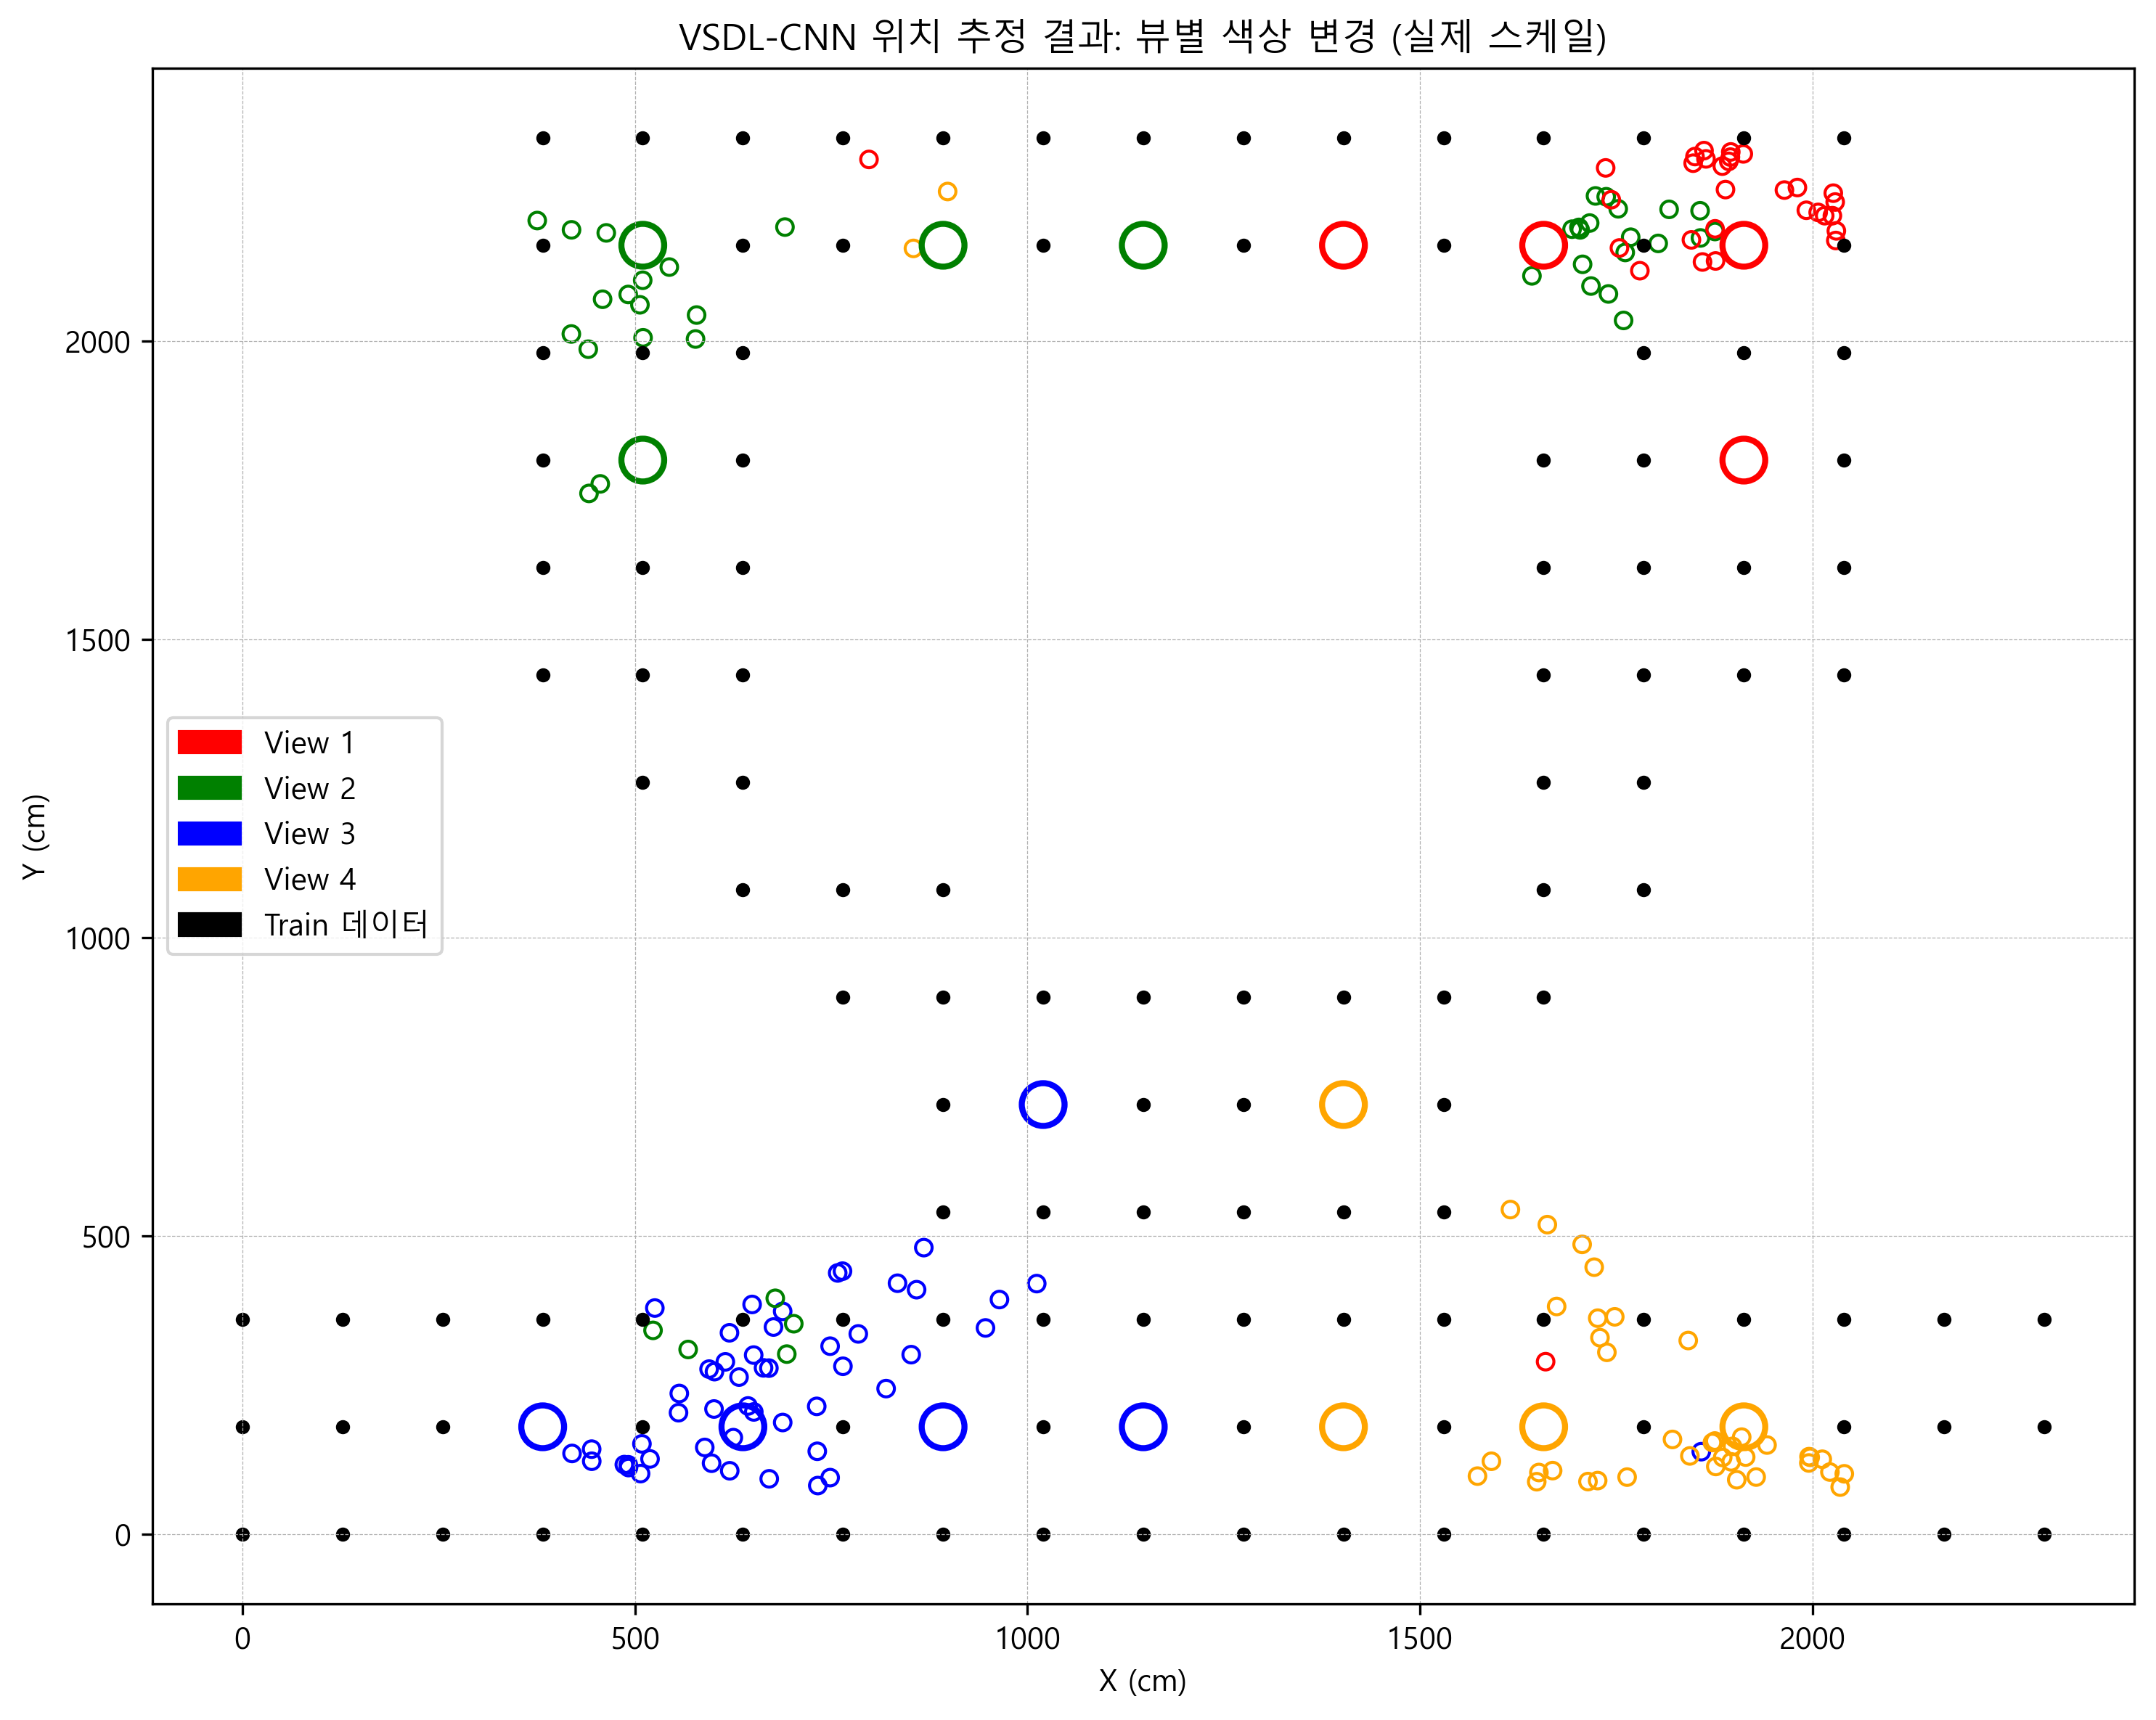

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 한글 폰트 및 마이너스 깨짐 방지
plt.rcParams['font.family']         = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus']= False

# CSI 공간의 실제 최대값 (학습 코드에서 사용된 값과 동일하게 설정)
max_x, max_y = 2295.0, 2340.0

# 1) 결과 불러오기
RESULT_FILE = "result_cnn_prediction_250701.txt"
result_normalized = np.loadtxt(RESULT_FILE) # 정규화된 값을 로드

# 예측값 역정규화
result_x = result_normalized[:, 0] * max_x
result_y = result_normalized[:, 1] * max_y

EXPERIMENT = 10
numTest    = 17 # TP (총 테스트 포인트 수)와 일치

# 2) 좌표 전체 리스트 정의 (이 부분은 이전과 동일하게 원본 스케일 유지)
y1_all = [0, 127.5, 255.0, 382.5, 510.0, 637.5, 765.0, 892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0, 1657.5, 1785.0, 1912.5, 2040.0, 2167.5, 2295.0, 
          0, 127.5, 255.0, 382.5, 510.0, 637.5, 765.0, 892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0, 1657.5, 1785.0, 1912.5, 2040.0, 2167.5, 2295.0, 
          0, 127.5, 255.0, 382.5, 510.0, 637.5, 765.0, 892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0, 1657.5, 1785.0, 1912.5, 2040.0, 2167.5, 2295.0, 
          892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0,
          892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0,
          765.0, 892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0, 1657.5,
          637.5, 765, 892.5, 1657.5, 1785,
          510, 637.5, 1657.5, 1785.0,
          382.5, 510, 637.5, 1657.5, 1785, 1912.5, 2040.0,
          382.5, 510, 637.5, 1657.5, 1785, 1912.5, 2040.0,
          382.5, 510, 637.5, 1657.5, 1785, 1912.5, 2040.0,
          382.5, 510, 637.5, 1785, 1912.5, 2040.0,
          382.5, 510.0, 637.5, 765.0, 892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0, 1657.5, 1785.0, 1912.5, 2040.0,
          382.5, 510.0, 637.5, 765.0, 892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0, 1657.5, 1785.0, 1912.5, 2040.0
        ]

y2_all = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180,
          360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360,
          540, 540, 540, 540, 540, 540,
          720, 720, 720, 720, 720, 720,
          900, 900, 900, 900, 900, 900, 900, 900,
          1080, 1080, 1080, 1080, 1080,
          1260, 1260, 1260, 1260,
          1440, 1440, 1440, 1440, 1440, 1440, 1440,
          1620, 1620, 1620, 1620, 1620, 1620, 1620,
          1800, 1800, 1800, 1800, 1800, 1800, 1800,
          1980, 1980, 1980, 1980, 1980, 1980,
          2160, 2160, 2160, 2160, 2160, 2160, 2160, 2160, 2160, 2160, 2160, 2160, 2160, 2160,
          2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340
        ]

# 3) train/test 인덱스 정의
train1 = [80,81,84,85,89,90,91,92,96,97,98,99,103,104,106,110,111,112,120,122,124,126,134,135,136,137,138,139,140]
train2 = [77,78,79,82,83,86,87,88,93,94,95,100,102,107,108,109,113,115,116,118,127,128,129,130,131,132,133]
train3 = [0,1,2,3,4,5,6,7,8,9,19,20,21,23,25,27,38,39,40,41,42,43,44,45,46,47,57,58,59,63,65,69,70,71,72]
train4 = [10,11,12,13,14,15,16,17,18,29,31,33,35,36,37,48,49,50,51,52,53,54,55,56,60,61,62,66,68,73,74,75,76]

test1  = [105,121,123,125]
test2  = [101,114,117,119] # test_idx에 114가 포함되는지 확인. 이전 코드에서는 없었음.
test3  = [22,24,26,28,64]
test4  = [30,32,34,67]

train_idx = sorted(train1 + train2 + train3 + train4)  # 학습 인덱스
test_idx  = sorted(test1  + test2  + test3  + test4 )  # 테스트 인덱스

# 4) 좌표 추출
y1 = [y1_all[i] for i in train_idx]  # 학습 X (원래 스케일)
y2 = [y2_all[i] for i in train_idx]  # 학습 Y (원래 스케일)
y3 = [y1_all[i] for i in test_idx ]  # 테스트 X (원래 스케일)
y4 = [y2_all[i] for i in test_idx ]  # 테스트 Y (원래 스케일)


# 5) 뷰 라벨 및 색상 매핑
view_labels = []
for idx in test_idx:
    if idx in test1:    view_labels.append(0)
    elif idx in test2: view_labels.append(1)
    elif idx in test3: view_labels.append(2)
    else:               view_labels.append(3)


# 방법 B: 직접 RGB 또는 이름으로 색상 리스트 정의
view_colors = ['red', 'green', 'blue', 'orange']

# 6) 시각화
plt.figure(figsize=(10,8), dpi=300)

for i in range(numTest):
    s, e = i*EXPERIMENT, (i+1)*EXPERIMENT
    c    = view_colors[view_labels[i]]
    
    # 예측된 위치 (역정규화된 result_x, result_y 사용)
    plt.scatter(result_x[s:e], result_y[s:e],
                s=30, marker='o', facecolors='none',
                edgecolors=c, linewidths=1)
    
    # 실제 테스트 포인트 위치 (y3, y4는 이미 원래 스케일)
    plt.scatter(y3[i], y4[i],
                s=200, marker='o', facecolors='none',
                edgecolors=c, linewidths=2)

# 학습 데이터 (y1, y2는 이미 원래 스케일)
plt.scatter(y1, y2,
            s=10, color='black', marker='o',
            facecolors='black', edgecolors='black',
            linewidths=1.5)

# 범례
view_patches = [mpatches.Patch(color=view_colors[i], label=f'View {i+1}') for i in range(4)]
train_patch  = mpatches.Patch(color='black', label='Train 데이터')
plt.legend(handles=view_patches+[train_patch], loc='center left')

plt.title('VSDL-CNN 위치 추정 결과: 뷰별 색상 변경 (실제 스케일)')
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
plt.grid(True, linestyle='--', linewidth=0.3)
plt.tight_layout()
plt.show()